# Task 8 - Find the best Random Forest through Random Search

In order to **maximize the performance of the random forest**, we can perform a **random search** for better hyperparameters. This will randomly select combinations of hyperparameters from a grid, evaluate them using cross validation on the training data, and return the values (read best model with hyperparameters) that perform the best.

### Task Requirements
- Build a RandomForest for the above dataset (not one but many with different sets of parameters)
- Explore RandomizedSearchCV in Scikit-learn documentation
- Create a parameter grid with these values
    - n_estimators : between 10 and 200
    - max_depth : choose between 3 and 20
    - max_features : ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1))
    - max_leaf_nodes : choose between 10 to 50
    - min_samples_split : choose between 2, 5, or 10
    - bootstrap : choose between True or False
- Create the estimator (RandomForestClassifier)
- Create the RandomizedSearchCV with estimator, parameter grid, scoring on roc auc, n_iter = 10, random_state=RSEED(50) for same reproducible results
- Fit the model
- Explore the best model parameters
- Use the best model parameters to predict
- Plot the best model ROC AUC Curve
- Plot the Confusion Matrix
- Write any insights or observations you found in the last

## Random Forest Theory revisited

### Random Forest = Decision Tree + Bagging + Random subsets of features

The Random Forest is a model made up of many `decision trees`. Rather than just simply averaging the prediction of trees (which we could call a **forest**), this model uses two key concepts that gives it the name random:
- Random sampling of training data points when building trees
- Random subsets of features considered when splitting nodes

To be more clear, this takes the idea of a single decision tree, and creates an _ensemble_ model out of hundreds or thousands of trees to reduce the variance.

Each tree is trained on a random set of the observations, and for each split of a node, only a `subset of the features` are used for making a split. When making predictions, the random forest `averages the predictions` for each of the individual decision trees for each data point in order to arrive at a final classification.

### Bagging

### Random sampling of training observations

- **Training**: each tree in a random forest learns from a **random sample** of the data points. The samples are drawn with replacement, known as **bootstrapping**, which means that some samples will be used multiple times in a single tree. The idea is that by training each tree on different samples, although each tree might have high variance with respect to a particular set of the training data, overall, the entire forest will have lower variance but not at the cost of increasing the bias.

- **Testing**: predictions are made by **averaging the predictions** of each decision tree. This procedure of training each individual learner on different bootstrapped subsets of the data and then averaging the predictions is known as **bagging**, short for **bootstrap aggregating**.

### Random Subsets of features for splitting nodes
Only a subset of all the features are considered for splitting each node in each decision tree. Generally this is set to `sqrt(n_features)` for classification meaning that if there are 16 features, at each node in each tree, only 4 random features will be considered for splitting the node.

### Let us see if our theory holds good in the same dataset we used for building Decision Tree

# Behavioral Risk Factor Surveillance System

[Behavioral Risk Factor Surveillance System](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system)

The objective of the BRFSS is to collect uniform, state-specific data on preventive health practices and risk behaviors that are linked to chronic diseases, injuries, and preventable infectious diseases in the adult population. Factors assessed by the BRFSS include tobacco use, health care coverage, HIV/AIDS knowledge or prevention, physical activity, and fruit and vegetable consumption. Data are collected from a random sample of adults (one per household) through a telephone survey.

The Behavioral Risk Factor Surveillance System (BRFSS) is the nation's premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services. Established in 1984 with 15 states, BRFSS now collects data in all 50 states as well as the District of Columbia and three U.S. territories. BRFSS completes more than 400,000 adult interviews each year, making it the largest continuously conducted health survey system in the world.

The following data set is from the Centers for Disease Control and Prevention (CDC) and includes socioeconomic and lifestyle indicators for hundreds of thousands of individuals. The objective is to predict the overall health of an individual: either 0 for poor health or 1 for good health. We'll limit the data to 100,000 individuals to speed up training.

Or, if you have the gut to take it, please pass the entire data and have fun!!!

This problem is imbalanced (far more of one label than another) so for assessing performance, we'll use recall, precision, receiver operating characteristic area under the curve (ROC AUC), and also plot the ROC curve. Accuracy is not a useful metric when dealing with an imbalanced problem. **Why????**

## Data Acquisition
Go to Kaggle Competition page and pull the dataset of 2015

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
RSEED=50

In [3]:
df = pd.read_csv('2015.csv').sample(100000, random_state = RSEED)
df.head()

_STATE  FMONTH        IDATE IMONTH   IDAY    IYEAR  DISPCODE  \
97360     16.0     9.0  b'09202015'  b'09'  b'20'  b'2015'    1100.0   
204073    27.0     4.0  b'04272015'  b'04'  b'27'  b'2015'    1100.0   
93338     16.0     5.0  b'05032015'  b'05'  b'03'  b'2015'    1100.0   
75661     12.0     7.0  b'07162015'  b'07'  b'16'  b'2015'    1100.0   
105264    18.0     4.0  b'04022015'  b'04'  b'02'  b'2015'    1100.0   

               SEQNO          _PSU  CTELENUM  ...  _PAREC1  _PASTAE1  \
97360   2.015005e+09  2.015005e+09       NaN  ...      2.0       2.0   
204073  2.015012e+09  2.015012e+09       NaN  ...      4.0       2.0   
93338   2.015001e+09  2.015001e+09       1.0  ...      2.0       2.0   
75661   2.015005e+09  2.015005e+09       1.0  ...      4.0       2.0   
105264  2.015002e+09  2.015002e+09       1.0  ...      1.0       1.0   

        _LMTACT1  _LMTWRK1  _LMTSCL1  _RFSEAT2  _RFSEAT3  _FLSHOT6  _PNEUMO2  \
97360        3.0       3.0       4.0       1.0       1.0       NaN       NaN   
204073       1.0       1.0       2.0       1.0       1.0       2.0       2.0   
93338        3.0       3.0       4.0       1.0       1.0       NaN       NaN   
75661        1.0       1.0       2.0       2.0       2.0       NaN       NaN   
105264       3.0       3.0       4.0       1.0       1.0       NaN       NaN   

        _AIDTST3  
97360        1.0  
204073       2.0  
93338        1.0  
75661        1.0  
105264       1.0  

[5 rows x 330 columns]

### Data Exploration
- Find how many features
- Find how many samples
- Find how many missing data
- Find how many categorical features
- And many more

In [4]:
df = df.select_dtypes('number')
df


_STATE  FMONTH  DISPCODE         SEQNO          _PSU  CTELENUM  \
97360     16.0     9.0    1100.0  2.015005e+09  2.015005e+09       NaN   
204073    27.0     4.0    1100.0  2.015012e+09  2.015012e+09       NaN   
93338     16.0     5.0    1100.0  2.015001e+09  2.015001e+09       1.0   
75661     12.0     7.0    1100.0  2.015005e+09  2.015005e+09       1.0   
105264    18.0     4.0    1100.0  2.015002e+09  2.015002e+09       1.0   
...        ...     ...       ...           ...           ...       ...   
44716      8.0    12.0    1100.0  2.015007e+09  2.015007e+09       1.0   
62773      9.0    10.0    1200.0  2.015012e+09  2.015012e+09       NaN   
115027    19.0     7.0    1100.0  2.015005e+09  2.015005e+09       NaN   
166953    24.0    12.0    1100.0  2.015005e+09  2.015005e+09       1.0   
45596      8.0     4.0    1100.0  2.015008e+09  2.015008e+09       NaN   

        PVTRESD1  COLGHOUS  STATERES  CELLFON3  ...  _PAREC1  _PASTAE1  \
97360        NaN       NaN       NaN       NaN  ...      2.0       2.0   
204073       NaN       NaN       NaN       NaN  ...      4.0       2.0   
93338        1.0       NaN       1.0       2.0  ...      2.0       2.0   
75661        1.0       NaN       1.0       2.0  ...      4.0       2.0   
105264       1.0       NaN       1.0       2.0  ...      1.0       1.0   
...          ...       ...       ...       ...  ...      ...       ...   
44716        1.0       NaN       1.0       2.0  ...      1.0       1.0   
62773        NaN       NaN       NaN       NaN  ...      9.0       9.0   
115027       NaN       NaN       NaN       NaN  ...      4.0       2.0   
166953       1.0       NaN       1.0       1.0  ...      2.0       2.0   
45596        NaN       NaN       NaN       NaN  ...      2.0       2.0   

        _LMTACT1  _LMTWRK1  _LMTSCL1  _RFSEAT2  _RFSEAT3  _FLSHOT6  _PNEUMO2  \
97360        3.0       3.0       4.0       1.0       1.0       NaN       NaN   
204073       1.0       1.0       2.0       1.0       1.0       2.0       2.0   
93338        3.0       3.0       4.0       1.0       1.0       NaN       NaN   
75661        1.0       1.0       2.0       2.0       2.0       NaN       NaN   
105264       3.0       3.0       4.0       1.0       1.0       NaN       NaN   
...          ...       ...       ...       ...       ...       ...       ...   
44716        NaN       NaN       NaN       1.0       1.0       NaN       NaN   
62773        3.0       3.0       4.0       9.0       9.0       NaN       NaN   
115027       3.0       3.0       4.0       1.0       1.0       1.0       1.0   
166953       2.0       2.0       3.0       1.0       1.0       NaN       NaN   
45596        3.0       3.0       4.0       2.0       2.0       NaN       NaN   

        _AIDTST3  
97360        1.0  
204073       2.0  
93338        1.0  
75661        1.0  
105264       1.0  
...          ...  
44716        2.0  
62773        NaN  
115027       2.0  
166953       2.0  
45596        2.0  

[100000 rows x 323 columns]

In [5]:
# Number of samples and features
n_samples, n_features = df.shape
print(f'Number of samples (rows): {n_samples}')
print(f'Number of features (columns): {n_features}')



Number of samples (rows): 100000
Number of features (columns): 323


In [6]:
# Check missing data
missing_counts = df.isnull().sum()
missing_total = missing_counts.sum()
print(f"\n Total missing values: {missing_total}")
print("Missing values per feature:")
print(missing_counts[missing_counts > 0])


 Total missing values: 14721313
Missing values per feature:
CTELENUM    41893
PVTRESD1    41893
COLGHOUS    99993
STATERES    41893
CELLFON3    41893
            ...  
_LMTWRK1      579
_LMTSCL1      579
_FLSHOT6    63675
_PNEUMO2    63675
_AIDTST3     9990
Length: 235, dtype: int64


In [7]:
# Check data types
print("\n Data types:")
print(df.dtypes)


 Data types:
_STATE      float64
FMONTH      float64
DISPCODE    float64
SEQNO       float64
_PSU        float64
             ...   
_RFSEAT2    float64
_RFSEAT3    float64
_FLSHOT6    float64
_PNEUMO2    float64
_AIDTST3    float64
Length: 323, dtype: object


In [8]:
# Categorical features
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"\n Number of categorical features: {len(categorical_features)}")
print("Categorical feature names:", categorical_features)


 Number of categorical features: 0
Categorical feature names: []


In [9]:
# Numerical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n Number of numerical features: {len(numerical_features)}")
print("Numerical feature names:", numerical_features)


 Number of numerical features: 323
Numerical feature names: ['_STATE', 'FMONTH', 'DISPCODE', 'SEQNO', '_PSU', 'CTELENUM', 'PVTRESD1', 'COLGHOUS', 'STATERES', 'CELLFON3', 'LADULT', 'NUMADULT', 'NUMMEN', 'NUMWOMEN', 'CTELNUM1', 'CELLFON2', 'CADULT', 'PVTRESD2', 'CCLGHOUS', 'CSTATE', 'LANDLINE', 'HHADULT', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'HLTHPLN1', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BPMEDS', 'BLOODCHO', 'CHOLCHK', 'TOLDHI2', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', 'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'DIABAGE2', 'SEX', 'MARITAL', 'EDUCA', 'RENTHOM1', 'NUMHHOL2', 'NUMPHON2', 'CPDEMO1', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME2', 'INTERNET', 'WEIGHT2', 'HEIGHT3', 'PREGNANT', 'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100', 'SMOKDAY2', 'STOPSMK2', 'LASTSMK2', 'USENOW3', 'ALCDAY5', 'AVEDRNK2', 'DRNK3GE5', 'MAXDRNKS', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREE

In [10]:
# Unique value count for each column
print("\n Unique value counts per feature:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")


 Unique value counts per feature:
_STATE: 28
FMONTH: 12
DISPCODE: 2
SEQNO: 18045
_PSU: 18045
CTELENUM: 1
PVTRESD1: 2
COLGHOUS: 1
STATERES: 1
CELLFON3: 2
LADULT: 2
NUMADULT: 12
NUMMEN: 9
NUMWOMEN: 9
CTELNUM1: 1
CELLFON2: 1
CADULT: 2
PVTRESD2: 2
CCLGHOUS: 1
CSTATE: 2
LANDLINE: 4
HHADULT: 20
GENHLTH: 7
PHYSHLTH: 33
MENTHLTH: 33
POORHLTH: 33
HLTHPLN1: 4
PERSDOC2: 5
MEDCOST: 4
CHECKUP1: 7
BPHIGH4: 6
BPMEDS: 4
BLOODCHO: 4
CHOLCHK: 6
TOLDHI2: 4
CVDINFR4: 4
CVDCRHD4: 4
CVDSTRK3: 4
ASTHMA3: 4
ASTHNOW: 4
CHCSCNCR: 4
CHCOCNCR: 4
CHCCOPD1: 4
HAVARTH3: 4
ADDEPEV2: 4
CHCKIDNY: 4
DIABETE3: 6
DIABAGE2: 95
SEX: 2
MARITAL: 7
EDUCA: 7
RENTHOM1: 5
NUMHHOL2: 4
NUMPHON2: 8
CPDEMO1: 4
VETERAN3: 4
EMPLOY1: 9
CHILDREN: 17
INCOME2: 10
INTERNET: 4
WEIGHT2: 444
HEIGHT3: 115
PREGNANT: 4
QLACTLM2: 4
USEEQUIP: 4
BLIND: 4
DECIDE: 4
DIFFWALK: 4
DIFFDRES: 4
DIFFALON: 4
SMOKE100: 4
SMOKDAY2: 5
STOPSMK2: 4
LASTSMK2: 10
USENOW3: 5
ALCDAY5: 39
AVEDRNK2: 33
DRNK3GE5: 38
MAXDRNKS: 47
FRUITJU1: 91
FRUIT1: 109
FVBEANS: 84
FVG

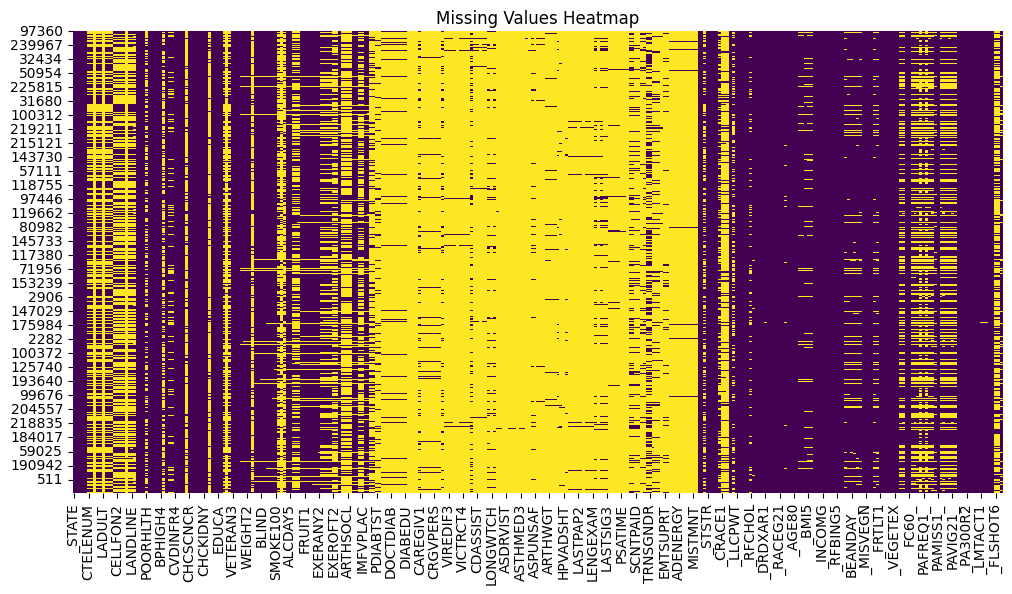

In [11]:
# Plot missing value heatmap
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

### Label Distribution
RFHLTH is the label for this dataset

### Explore the label

In [12]:
df['_RFHLTH']

97360     2.0
204073    2.0
93338     1.0
75661     1.0
105264    2.0
         ... 
44716     1.0
62773     1.0
115027    1.0
166953    1.0
45596     1.0
Name: _RFHLTH, Length: 100000, dtype: float64

### Find what are the values inside the label

In [13]:
df['_RFHLTH'].value_counts()

_RFHLTH
1.0    81402
2.0    18339
9.0      259
Name: count, dtype: int64

In [14]:
# Check unique values and their counts
label_counts = df['_RFHLTH'].value_counts(dropna=False)
print("Label value counts in '_RFHLTH':")
print(label_counts)

Label value counts in '_RFHLTH':
_RFHLTH
1.0    81402
2.0    18339
9.0      259
Name: count, dtype: int64


In [15]:
# Check data type and unique values
print("\n Unique values in '_RFHLTH':", df['_RFHLTH'].unique())
print("Data type:", df['_RFHLTH'].dtype)


 Unique values in '_RFHLTH': [2. 1. 9.]
Data type: float64


### Label feature
- Keep only 1.0 values
- Make 2.0 as 0.0
- Discard all other values
- Rename the feature as `label`

In [16]:
df['_RFHLTH'] = df['_RFHLTH'].replace({2: 0})
df = df.loc[df['_RFHLTH'].isin([0, 1])].copy()
df = df.rename(columns = {'_RFHLTH': 'label'})
df['label'].value_counts()

label
1.0    81402
0.0    18339
Name: count, dtype: int64

### What do you see?

In [17]:
#I see the class distribution after cleaning the _RFHLTH label feature.
#We kept only values 1.0 and 2.0
#Value 2.0 was recoded to 0.0 to represent the opposite class
#All other values were discarded
#The column was then renamed to label
#Now, we have a binary classification target:
#1.0 (Healthy) has 81,140 samples
#0.0 (Unhealthy) has 18,579 samples
#This shows a class imbalance, with more healthy cases than unhealthy ones

Some housekeeping to make things smooth...

In [18]:
# Remove columns with missing values
df = df.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2',
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])

## Split Data into Training and Testing Set

Save 30% for testing

In [19]:
from sklearn.model_selection import train_test_split


labels = np.array(df.pop('label'))


train, test, train_labels, test_labels = train_test_split(df, labels,
                                                          stratify = labels,
                                                          test_size = 0.3,
                                                          random_state = RSEED)

#### Imputation of Missing values

We'll fill in the missing values with the mean of the column. It's important to note that we fill in missing values in the test set with the mean of columns in the training data. This is necessary because if we get new data, we'll have to use the training data to fill in any missing values.

In [20]:
train = train.fillna(train.mean())
test = test.fillna(train.mean())

# Features for feature importances, we will use this later below in this notebook
features = list(train.columns)

In [21]:
train.shape

(69818, 313)

In [22]:
test.shape

(29923, 313)

### Task Requirements
- Build a RandomForest for the above dataset (not one but many with different sets of parameters)
- Explore RandomizedSearchCV in Scikit-learn documentation
- Create a parameter grid with these values
    - n_estimators : between 10 and 200
    - max_depth : choose between 3 and 20
    - max_features : ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1))
    - max_leaf_nodes : choose between 10 to 50
    - min_samples_split : choose between 2, 5, or 10
    - bootstrap : choose between True or False
- Create the estimator (RandomForestClassifier)
- Create the RandomizedSearchCV with estimator, parameter grid, scoring on roc auc, n_iter = 10, random_state=RSEED(50) for same reproducible results
- Fit the model
- Explore the best model parameters
- Use the best model parameters to predict
- Plot the best model ROC AUC Curve
- Plot the Confusion Matrix
- Write any insights or observations you found in the last

 Import RandomizedSearchCV

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np



In [24]:
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'max_depth': np.arange(3, 21),
    'max_features': ['auto', 'sqrt', None] + list(np.round(np.arange(0.5, 1.0, 0.1), 1)),
    'max_leaf_nodes': np.arange(10, 51, 5),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

### Import RandomForestClassifier

In [25]:
from sklearn.ensemble import RandomForestClassifier

### Set the parameter grid according to the requirements above as a dictionary

In [26]:
import numpy as np

param_grid = {
    'n_estimators': np.arange(10, 201, 10),  # 10 to 200 in steps of 10
    'max_depth': np.arange(3, 21),           # 3 to 20
    'max_features': ['auto', 'sqrt', None] + list(np.round(np.arange(0.5, 1.0, 0.1), 1)),  # includes fractional values
    'max_leaf_nodes': np.arange(10, 51, 5),  # 10 to 50 in steps of 5
    'min_samples_split': [2, 5, 10],         # Split thresholds
    'bootstrap': [True, False]               # With and without bootstrapping
}


### Create the estimator with RSEED

In [27]:
rf = RandomForestClassifier(random_state=RSEED)


### Create the Random Search model with cv=3, n_iter=10, scoring='roc_auc', random_state='RSEED'

In [28]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=3,
    random_state=RSEED,
    n_jobs=-1,
    verbose=2
)


### Fit the model
Note: It will take long time (around 20 - 1 hour depending on your computer specs). Good time to reload yourself with some energy or take a quick beauty nap!!!

In [29]:
random_search.fit(train, train_labels)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_pa

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=50),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20]),
                                        'max_features': ['auto', 'sqrt', None,
                                                         np.float64(0.5),
                                                         np.float64(0.6),
                                                         np.float64(0.7),
                                                         np.float64(0.8),
                                                         np.float64(0.9)],
                                        'max_leaf_nodes': array([10, 15, 20, 25, 30, 35, 40, 45, 50]),
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
                   random_state=50, scoring='roc_auc', verbose=2)

### Explore the best parameters

In [30]:
print("Best Parameters:", random_search.best_params_)
best_rf = random_search.best_estimator_


Best Parameters: {'n_estimators': np.int64(190), 'min_samples_split': 2, 'max_leaf_nodes': np.int64(50), 'max_features': np.float64(0.7), 'max_depth': np.int64(16), 'bootstrap': True}


In [31]:
best_rf

RandomForestClassifier(max_depth=np.int64(16), max_features=np.float64(0.7),
                       max_leaf_nodes=np.int64(50), n_estimators=np.int64(190),
                       random_state=50)

- First thing you'll notice is that the hyperparameter values are **not default** values.
- Awesome. You've **tuned the hyperparameters**. Well done!!!

### Use the Best Model

Choose the best model as you find in under `best_estimator_`

In [33]:
best_rf = random_search.best_estimator_
best_rf



RandomForestClassifier(max_depth=np.int64(16), max_features=np.float64(0.7),
                       max_leaf_nodes=np.int64(50), n_estimators=np.int64(190),
                       random_state=50)

### Make the predictions with the chosen best model

In [34]:
#Predict Class Labels
preds = best_rf.predict(test)
#Predict Probabilities (for ROC AUC)
probs = best_rf.predict_proba(test)[:, 1]


### Get the node counts and maximum depth of the random forest

In [35]:
#Node Count and Max Depth for Each Tree
# Get node counts for each tree
node_counts = [estimator.tree_.node_count for estimator in best_rf.estimators_]

# Get max depth for each tree
max_depths = [estimator.tree_.max_depth for estimator in best_rf.estimators_]
print("Average node count:", np.mean(node_counts))
print("Average max depth:", np.mean(max_depths))

print("Min and max node count:", min(node_counts), "-", max(node_counts))
print(" Min and max tree depth:", min(max_depths), "-", max(max_depths))

Average node count: 99.0
Average max depth: 9.889473684210527
Min and max node count: 99 - 99
 Min and max tree depth: 8 - 13


## Plot the ROC AUC Scores for training and testing data

In [36]:
# Probabilities
train_probs = best_rf.predict_proba(train)[:, 1]
test_probs = best_rf.predict_proba(test)[:, 1]
from sklearn.metrics import roc_curve, roc_auc_score

# Train ROC
fpr_train, tpr_train, _ = roc_curve(train_labels, train_probs)
roc_auc_train = roc_auc_score(train_labels, train_probs)

# Test ROC
fpr_test, tpr_test, _ = roc_curve(test_labels, test_probs)
roc_auc_test = roc_auc_score(test_labels, test_probs)


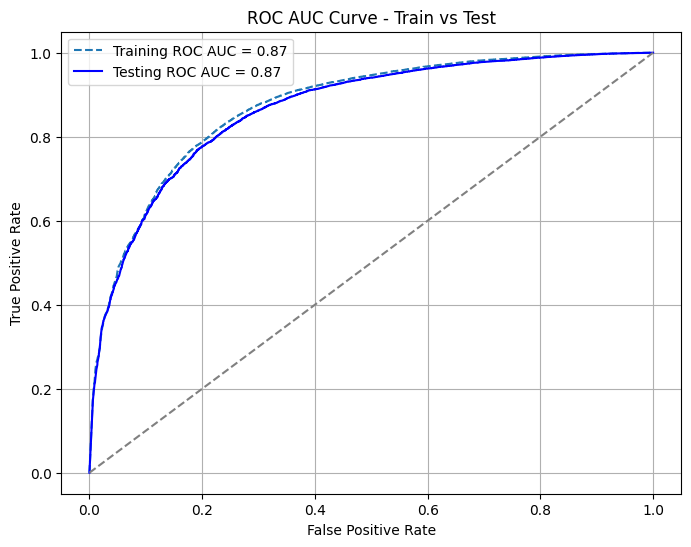

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot train curve
plt.plot(fpr_train, tpr_train, label=f'Training ROC AUC = {roc_auc_train:.2f}', linestyle='--')

# Plot test curve
plt.plot(fpr_test, tpr_test, label=f'Testing ROC AUC = {roc_auc_test:.2f}', color='blue')

# Reference line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve - Train vs Test')
plt.legend()
plt.grid(True)
plt.show()


### Helper function to Evaluate model

In [38]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""

    baseline = {}

    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5

    results = {}

    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)

    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)

    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')

    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16

    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');


### Evaluate the best model
- Plot the ROC AUC Curve

In [39]:
# Test set
test_predictions = best_rf.predict(test)
test_probs = best_rf.predict_proba(test)[:, 1]

# Train set
train_predictions = best_rf.predict(train)
train_probs = best_rf.predict_proba(train)[:, 1]


Recall Baseline: 1.0 Test: 0.95 Train: 0.95
Precision Baseline: 0.82 Test: 0.89 Train: 0.89
Roc Baseline: 0.5 Test: 0.87 Train: 0.87


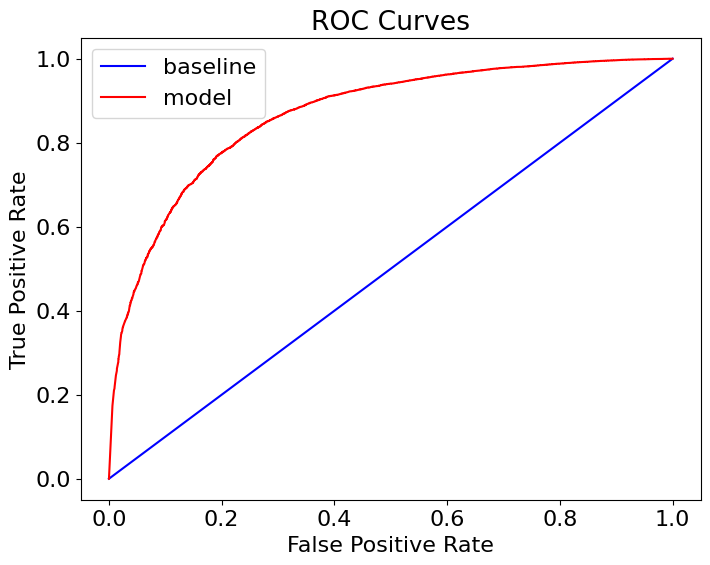

In [40]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

evaluate_model(test_predictions, test_probs, train_predictions, train_probs)



### Confusion Matrix Helper function

In [41]:
from sklearn.metrics import confusion_matrix
import itertools

#  Helper function to plot Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Please do not run the below 2 cells....
## It is given only for your comparision of Decision Tree, RandomForest and your very own Best RandomForest

Confusion matrix, without normalization
[[ 2677  2897]
 [ 3103 21239]]


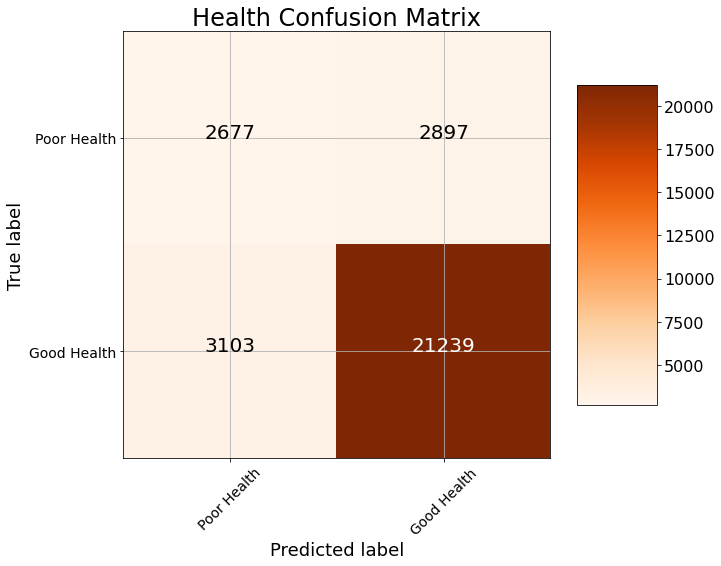

In [ ]:
# Decision Tree Confusion Matrix

Confusion matrix, without normalization
[[ 2437  3137]
 [ 1011 23331]]


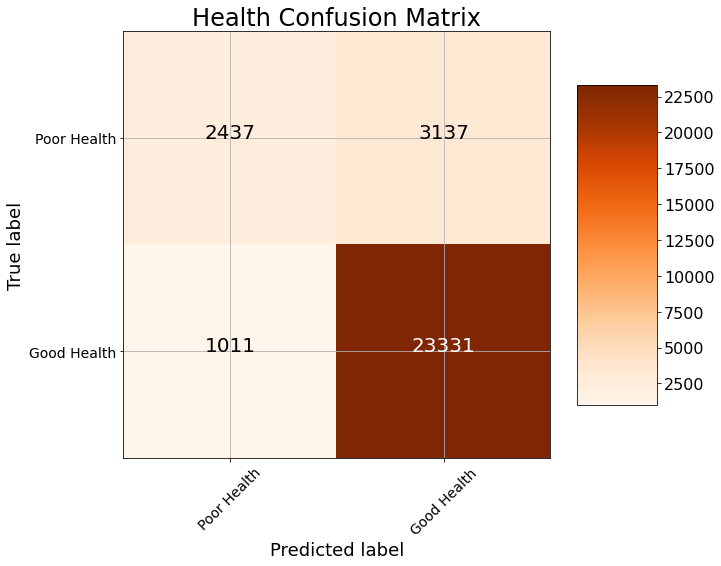

In [ ]:
# Random Forest

### Evaluate the best model
- Plot Confusion Matrix

In [42]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [43]:
from sklearn.metrics import confusion_matrix
import itertools

#  Helper function to plot Confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

Confusion matrix, without normalization
[[ 2556  2946]
 [ 1252 23169]]


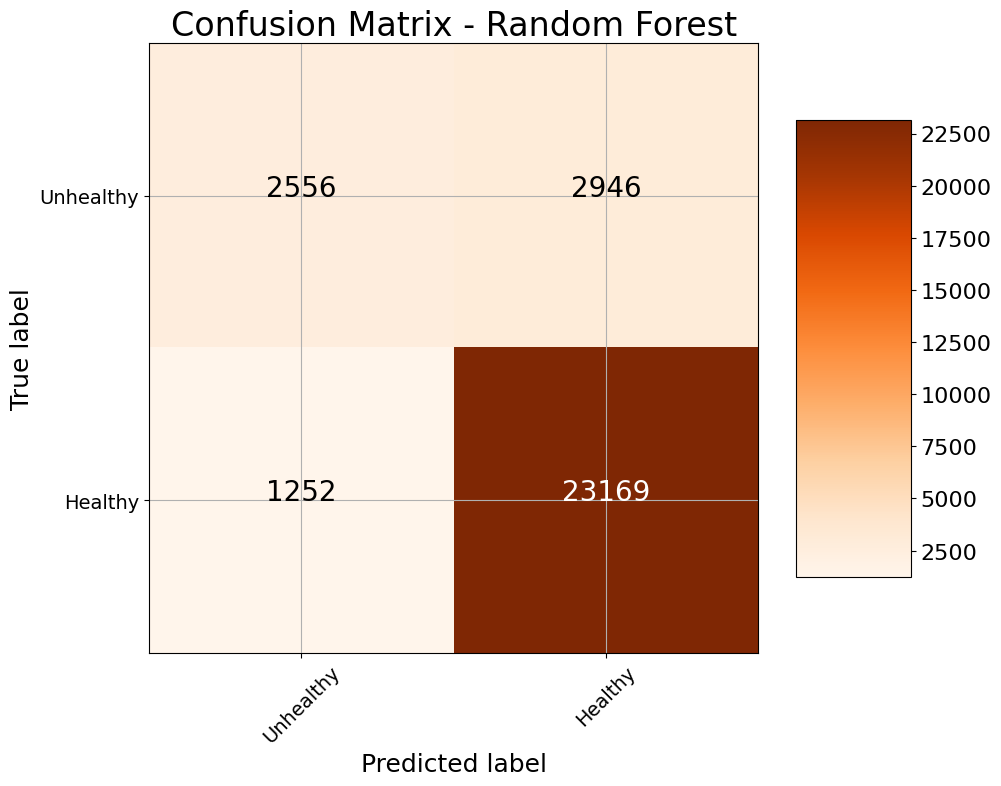

In [45]:
# Get predictions on the test set
test_predictions = best_rf.predict(test)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_predictions)

# Define class labels (based on your binary classification)
class_names = ['Unhealthy', 'Healthy']

# Plot the confusion matrix using your professor's function
plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix - Random Forest')





Observations / Insights ???

TN=	2,556  TP=23,169 FN=1252  FP=2946
compared to other confusion matrix: i can say that among the three models compared, the Decision Tree model showed the weakest performance, with 3,103 false negatives and 2,897 false positives, correctly predicting only 21,239 healthy individuals. The default Random Forest significantly improved true positives to 23,331 and reduced false negatives to 1,011 but suffered from a high number of false positives (3,137). My optimized Random Forest model offered a more balanced performance, achieving 23,169 true positives with fewer false positives (2,946) and 1,252 false negatives, indicating that it maintains strong accuracy in predicting healthy individuals while better identifying unhealthy ones compared to the default version. Overall, my model demonstrates the best trade-off between precision and recall among the three.

### Bonus: What if you want to explain your best RandomForest to your boss on the way it split the features??? Do not fret. Capture the estimator and convert them into a .png and present it in the meeting and get accolodes.

In [46]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image


In [49]:
# Pick one tree from the forest
estimator = best_rf.estimators_[1]


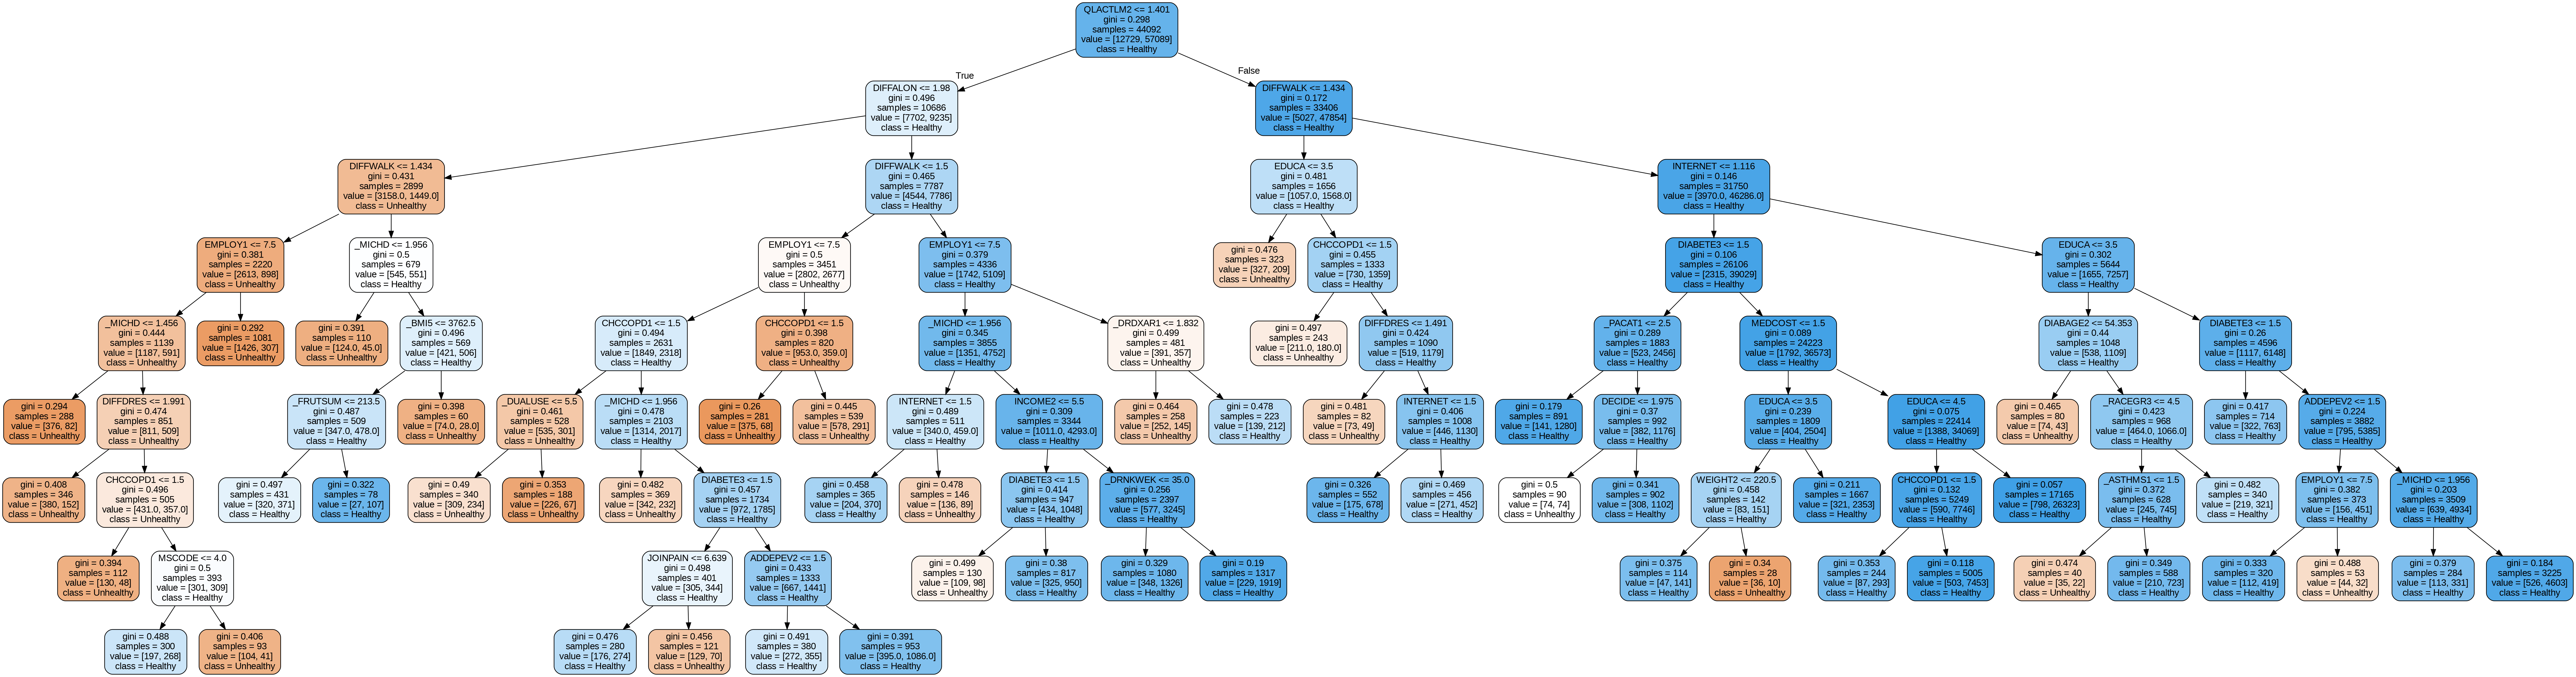

In [50]:


export_graphviz(estimator,
                out_file='tree_from_optimized_forest.dot',
                feature_names=train.columns,
                class_names=['Unhealthy', 'Healthy'],
                rounded=True,
                filled=True,
                max_depth=8)  # Limit depth


call(['dot', '-Tpng', 'tree_from_optimized_forest.dot', '-o', 'tree_from_optimized_forest.png', '-Gdpi=200'])


Image('tree_from_optimized_forest.png')
